In [3]:
import sys
sys.path.insert(0, '/home/nasha_voxelsafety_com/voxel/')
from experimental.shared.ppe_detector.test_ppe_detector import SampleDataset, TestDetectorAsClassifier2
import yaml
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()

with open('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe_detector/config_evaluate_safetyvest.yaml', encoding="utf-8") as config_text:
    parsed_config = yaml.safe_load(config_text)
print(parsed_config)
test_classifier = TestDetectorAsClassifier2(config = parsed_config)
test_classifier.load_dataset()

{'data': {'path': '/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full', 'labels': ['no_vest', 'vest'], 'width': 1024, 'height': 608}, 'model': {'path': '/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/ppe_detector/traced_detr.pth', 'type': 'DETR'}, 'experiments': {'name': 'production_vest_detector', 'object': 'SAFETY_VEST', 'cropped': 1}}


wandb: Currently logged in as: voxel-wandb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = str(p.argmax())
#         import pdb; pdb.set_trace()
#         text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, cl, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=4, # len(labels) l = ["hardhat"] == 1
                                                             ignore_mismatched_sizes=True, torchscript=False)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [6]:
model = Detr(lr=9e-5, lr_backbone=1e-5, weight_decay=1e-4)
# print(model)

model.load_state_dict(torch.load('/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/ppe_detector/detr_trained_11_epochs.pth'))
model.eval()


model = model.to(test_classifier.device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 800, 1233])
torch.Size([1, 800, 1233])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock01_cha_scenarios_SAFETY_VEST_positive_45185_frame_12_113407.jpg',)


/home/nasha_voxelsafety_com/.cache/bazel/_bazel_nasha_voxelsafety_com/3cd1dace9679a4d7a89f2d6e64961b96/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


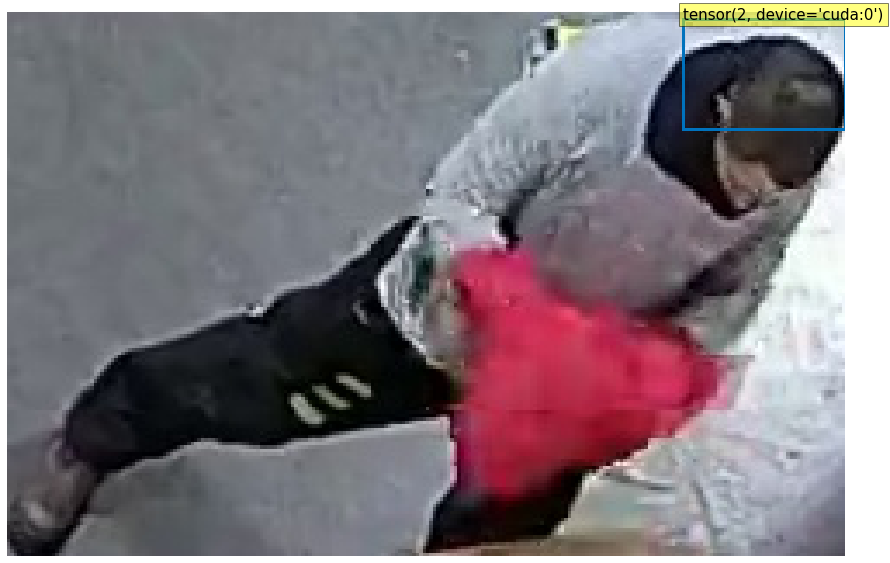

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1200, 800])
torch.Size([1, 1200, 800])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock03_cha_scenarios_SAFETY_VEST_negative_43567_frame_20_114139.jpg',)


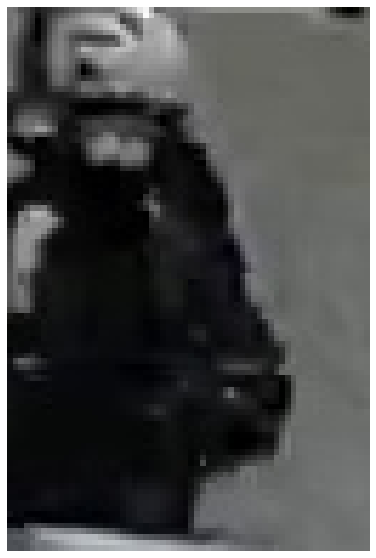

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1334, 567])
torch.Size([1, 1334, 567])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_59784_frame_5_113989.jpg',)


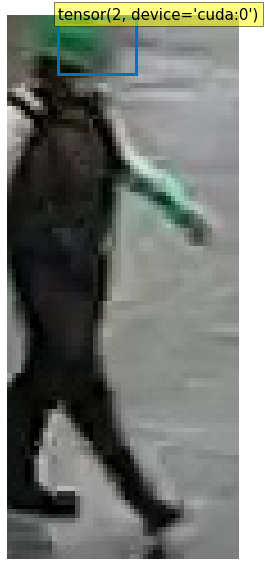

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 704])
torch.Size([1, 1332, 704])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_doors_14_20_cha_scenarios_SAFETY_VEST_positive_43193_frame_14_113310.jpg',)


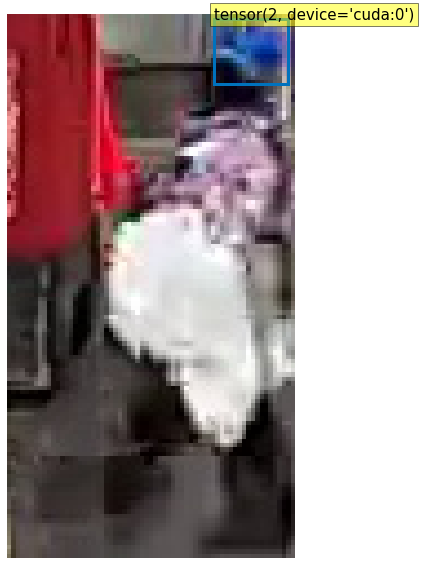

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 629])
torch.Size([1, 1333, 629])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock03_cha_scenarios_SAFETY_VEST_positive_43480_frame_24_113522.jpg',)


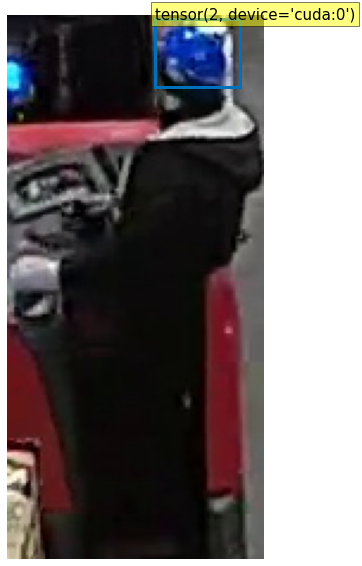

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 673])
torch.Size([1, 1333, 673])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock01_cha_scenarios_SAFETY_VEST_negative_59439_frame_3_114628.jpg',)


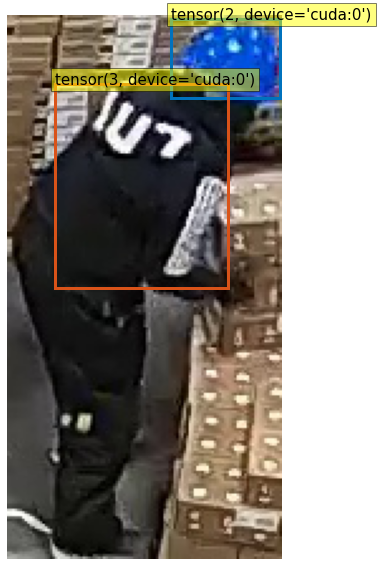

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 594])
torch.Size([1, 1333, 594])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_doors_14_20_cha_scenarios_SAFETY_VEST_positive_43193_frame_19_113324.jpg',)


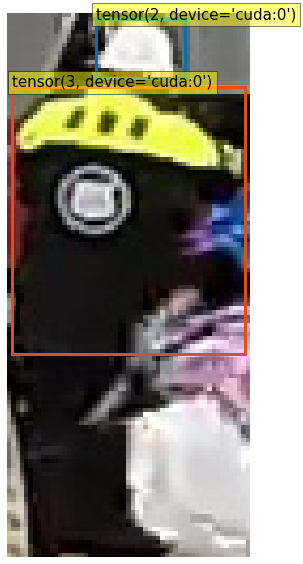

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 630])
torch.Size([1, 1333, 630])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock03_cha_scenarios_SAFETY_VEST_positive_43480_frame_14_113522.jpg',)


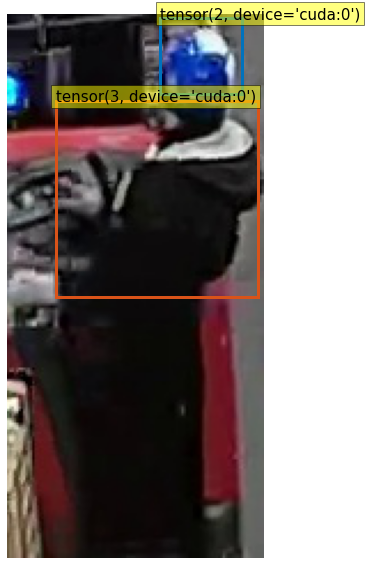

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 585])
torch.Size([1, 1333, 585])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_58212_frame_4_114145.jpg',)


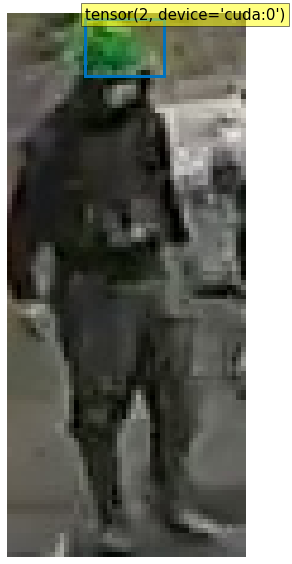

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 800, 1296])
torch.Size([1, 800, 1296])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock01_cha_scenarios_SAFETY_VEST_negative_59510_frame_14_115131.jpg',)


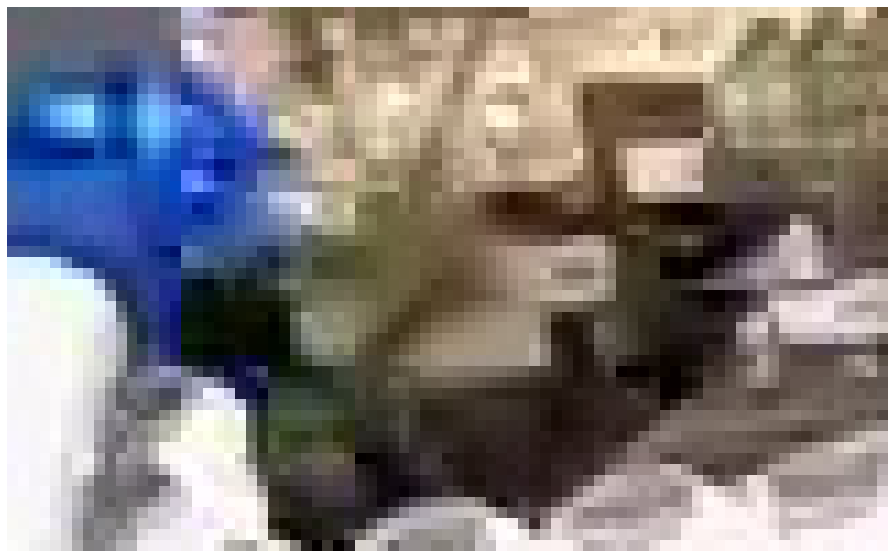

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 717])
torch.Size([1, 1332, 717])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock01_cha_scenarios_SAFETY_VEST_negative_59439_frame_4_114628.jpg',)


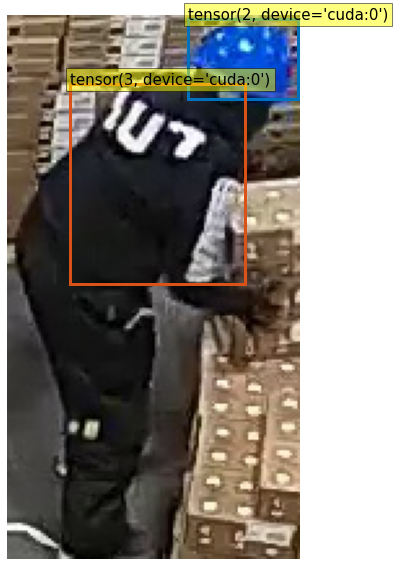

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 648])
torch.Size([1, 1332, 648])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_54567_frame_3_113646.jpg',)


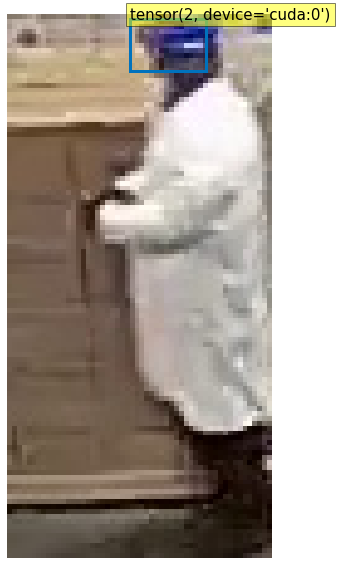

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 604])
torch.Size([1, 1333, 604])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_negative_43723_frame_22_114556.jpg',)


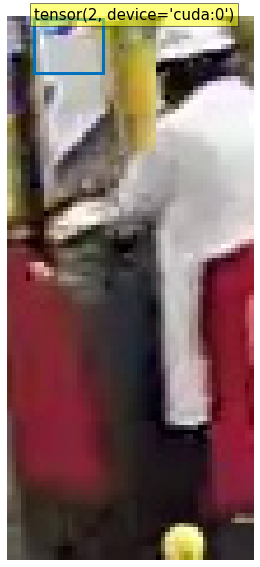

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 800, 1072])
torch.Size([1, 800, 1072])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock01_cha_scenarios_SAFETY_VEST_positive_45185_frame_21_113407.jpg',)


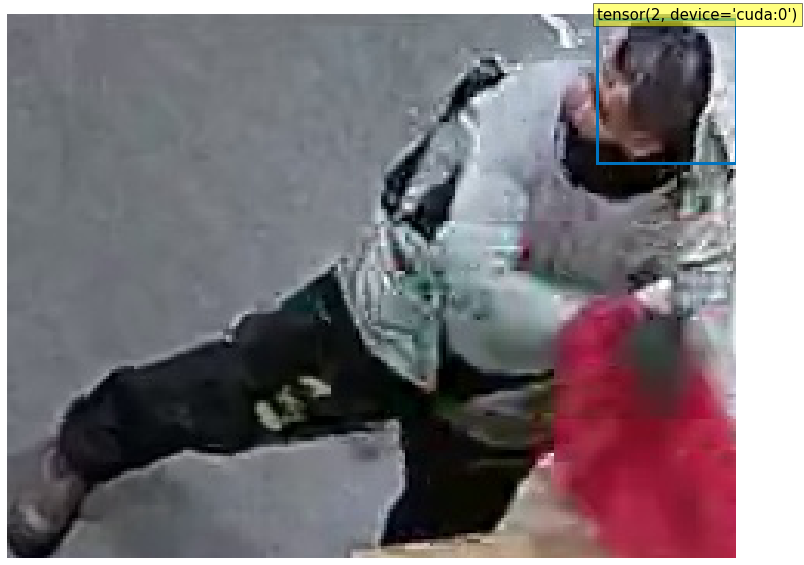

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1333, 630])
torch.Size([1, 1333, 630])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_58212_frame_21_114145.jpg',)


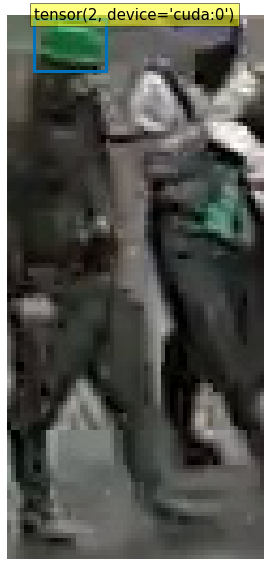

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1334, 582])
torch.Size([1, 1334, 582])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_negative_46178_frame_22_114421.jpg',)


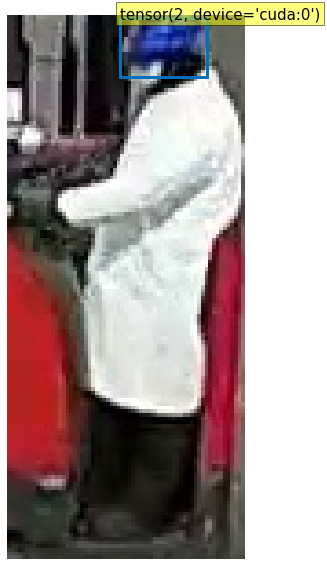

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 591])
torch.Size([1, 1332, 591])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_44704_frame_6_113692.jpg',)


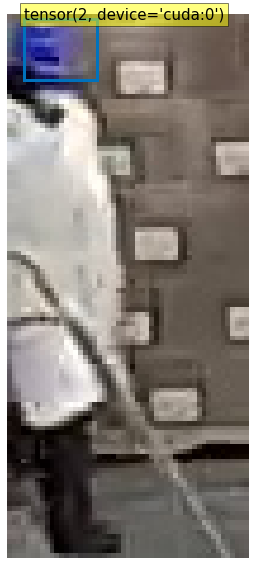

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 678])
torch.Size([1, 1332, 678])
('/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/scenario_test_full/no_vest/uscold_laredo_dock04_cha_scenarios_SAFETY_VEST_positive_54567_frame_7_113646.jpg',)


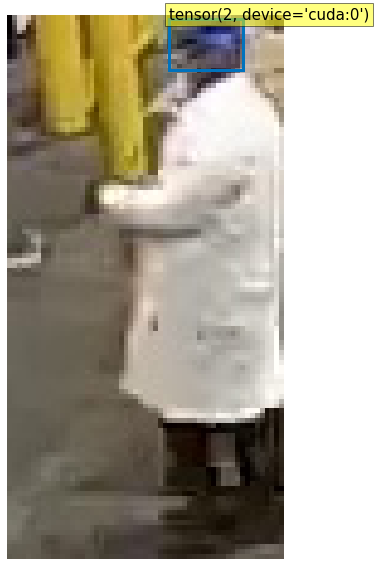

dict_keys(['pixel_values', 'pixel_mask'])
torch.Size([1, 3, 1332, 753])
torch.Size([1, 1332, 753])


KeyboardInterrupt: 

In [7]:
for inputs, labels, name, original_size, encodings in test_classifier.test_dataloaders:
   
    inputs = inputs.to(test_classifier.device)
    labels = labels.to(test_classifier.device)
    
    print(encodings.keys())
    pixel_values = encodings["pixel_values"].squeeze(axis=0).to(test_classifier.device)
    print(pixel_values.shape)
    pixel_mask = encodings["pixel_mask"].squeeze(axis=0).to(test_classifier.device)
    print(pixel_mask.shape)
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    
    # keep only predictions of queries with 0.9+ confidence (excluding no-object class)
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    
    print(name)
    im = Image.open(name[0])
    # rescale bounding boxes
    target_sizes = torch.tensor(im.size[::-1]).unsqueeze(0).to(test_classifier.device)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]
    
    
    plot_results(im, probas[keep], bboxes_scaled)
    
    

In [ ]:
import torch

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# rescale bounding boxes
target_sizes = torch.tensor(im.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

In [ ]:
plot_results(im, probas[keep], bboxes_scaled)

In [22]:
model_1 = Detr(lr=9e-5, lr_backbone=1e-5, weight_decay=1e-4)

# print(model_1)
model_1.load_state_dict(torch.load('/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/ppe_detector/detr_trained_11_epochs.pth'))
model_1.eval()
model_1 = model_1.to(test_classifier.device)

model_trace = torch.jit.trace(model_1,[pixel_values, pixel_mask],strict=False)
torch.jit.save(model_trace, '/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/ppe_detector/traced_detr.pt')

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model_2 = torch.jit.load('/home/nasha_voxelsafety_com/voxel/experimental/nasha/models/ppe_detector/traced_detr.pt')

model_2 = model_2.eval().to(test_classifier.device)

print(model_2)

RecursiveScriptModule(
  original_name=Detr
  (model): RecursiveScriptModule(
    original_name=DetrForObjectDetection
    (model): RecursiveScriptModule(
      original_name=DetrModel
      (backbone): RecursiveScriptModule(
        original_name=DetrConvModel
        (conv_encoder): RecursiveScriptModule(
          original_name=DetrTimmConvEncoder
          (model): RecursiveScriptModule(
            original_name=FeatureListNet
            (conv1): RecursiveScriptModule(original_name=Conv2d)
            (bn1): RecursiveScriptModule(original_name=DetrFrozenBatchNorm2d)
            (act1): RecursiveScriptModule(original_name=ReLU)
            (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
            (layer1): RecursiveScriptModule(
              original_name=Sequential
              (0): RecursiveScriptModule(
                original_name=Bottleneck
                (conv1): RecursiveScriptModule(original_name=Conv2d)
                (bn1): RecursiveScriptModule(original

In [25]:
pred_2 = model_2(pixel_values=pixel_values, pixel_mask=pixel_mask)

In [27]:
from transformers.models.detr.modeling_detr import DetrObjectDetectionOutput

In [29]:
pred_detr = DetrObjectDetectionOutput(logits=pred_2['logits'], pred_boxes=pred_2['pred_boxes'], last_hidden_state=pred_2['last_hidden_state'],encoder_last_hidden_state=pred_2['encoder_last_hidden_state'])

In [28]:
pred_2.keys()

dict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])